In [1]:
import torch
import optuna
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pathlib

/mnt/ACA058A9A0587C30/Faks/Master/SIAP-NM/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def df_to_X_y_vector(df, lags, future):
    X = []
    y = []
    for i in range(len(df) - lags - future):
        x_window_rows = df.iloc[i:i + lags]
        x_row = [list(x_window_rows.iloc[j]) for j in range(lags)]
        X.append(x_row)
        y_window_rows = df.iloc[i + lags:i + lags + future]
        y_row = [y_window_rows.iloc[j]['Detections'] for j in range(future)]
        y.append(y_row)
    return np.array(X), np.array(y)

In [3]:
def get_df(path):
    df = pd.read_csv(path)
    df = df.drop(['WeatherDescription', 'Unnamed: 0', 'index'], axis=1)
    df = pd.get_dummies(df, columns=['WeatherMain'], prefix='WeatherMain')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Year'] = df['Timestamp'].dt.year
    df['Month'] = df['Timestamp'].dt.month
    df['Day'] = df['Timestamp'].dt.day
    df['Hour'] = df['Timestamp'].dt.hour
    df = df.drop(['Timestamp', 'WeatherMain_Snow', 'Year'], axis=1)
    return df_to_X_y_vector(df, 288, 288)

In [4]:
# path = '../../train_belgrade.csv'
# X, y = get_df(path)
# X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
# X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
# # X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
# # save all data to csv files and save the shape of the data
# pathlib.Path('data').mkdir(parents=True, exist_ok=True)
# np.savetxt('data/X_train_raw.csv', X_train_raw.reshape(X_train_raw.shape[0], -1), delimiter=',')
# np.savetxt('data/y_train_raw.csv', y_train_raw, delimiter=',')
# np.savetxt('data/X_val_raw.csv', X_val_raw.reshape(X_val_raw.shape[0], -1), delimiter=',')
# np.savetxt('data/y_val_raw.csv', y_val_raw, delimiter=',')
# np.savetxt('data/X_test_raw.csv', X_test_raw.reshape(X_test_raw.shape[0], -1), delimiter=',')
# np.savetxt('data/y_test_raw.csv', y_test_raw, delimiter=',')


In [6]:
# load data from csv files
X_train_raw = np.loadtxt('data/X_train_raw.csv', delimiter=',').reshape(-1, 288, 8)
y_train_raw = np.loadtxt('data/y_train_raw.csv', delimiter=',')
X_val_raw = np.loadtxt('data/X_val_raw.csv', delimiter=',').reshape(-1, 288, 8)
y_val_raw = np.loadtxt('data/y_val_raw.csv', delimiter=',')
X_test_raw = np.loadtxt('data/X_test_raw.csv', delimiter=',').reshape(-1, 288, 8)
y_test_raw = np.loadtxt('data/y_test_raw.csv', delimiter=',')
print(X_train_raw.shape, y_train_raw.shape, X_val_raw.shape, y_val_raw.shape, X_test_raw.shape, y_test_raw.shape)

(11248, 288, 8) (11248, 288) (1406, 288, 8) (1406, 288) (1407, 288, 8) (1407, 288)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [8]:
X_train = torch.tensor(X_train_raw, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_raw, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val_raw, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val_raw, dtype=torch.float32).to(device)


X_train = X_train.permute(0, 2, 1)
X_val = X_val.permute(0, 2, 1)


print(X_train.shape, y_train.shape)

torch.Size([11248, 8, 288]) torch.Size([11248, 288])


In [9]:
class CustomLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, **kwargs):
        super().__init__()
        self.last_layer = kwargs.pop('last_layer', False)
        self.lstm = nn.GRU(input_dim, hidden_size, **kwargs)

    def forward(self, x):
        output, _ = self.lstm(x)
        if self.last_layer:
            return output[:, -1, :]
        return output


In [10]:
class ForecastModel(nn.Module):
    def __init__(self, trial, input_dim, output_dim):
        super().__init__()
        self.num_layers = trial.suggest_int('num_layers', 1, 3)
        self.dropout = trial.suggest_float('dropout', 0.05, 0.25)
        self.hidden_size = trial.suggest_int('hidden_size', 16, 128)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.rnn_layers = []
        self.conv = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=24, stride=6)
        # calculate the input size for the first layer
        first_input_dim = (288 - 24) // 6 + 1
        for i in range(self.num_layers):
            input_size = self.hidden_size if i != 0 else first_input_dim
            hidden_size = self.hidden_size if i != self.num_layers - 1 else 96
            self.rnn_layers.append(CustomLSTM(input_size, hidden_size, batch_first=True))
            self.rnn_layers.append(nn.Dropout(self.dropout))
        self.rnn_layers = nn.ModuleList(self.rnn_layers)
        self.transpose_conv = nn.ConvTranspose1d(in_channels=8, out_channels=8, kernel_size=6, stride=3)
        self.flattned_size = ((hidden_size - 1) * 3 + 6)*8
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self.flattned_size, self.output_dim)
        

    def forward(self, x):
        x = self.conv(x)
        for layer in self.rnn_layers:
            x = layer(x)
        x = self.transpose_conv(x)
        x = F.relu(x)
        # print(x.shape)
        x = self.flatten(x)
        x = self.fc(x)
        x = F.relu(x)
        return x

In [11]:
trial_data = {}

In [12]:
def objective(trial):
    # Assuming data preparation steps are already done, and you have X_train, y_train, X_val, y_val as tensors
    # print('Inputs:', X_train.shape, y_train.shape)
    
    model = ForecastModel(trial, input_dim=8, output_dim=288).to(device)

    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=trial.suggest_float('lr', 1e-5, 1e-3, log=True))
    
    # Example: Train the model
    epochs = 10
    mini_batch_size = 32
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for i in range(0, len(X_train), mini_batch_size):
            optimizer.zero_grad()
            X_batch = X_train[i:i+mini_batch_size]
            y_batch = y_train[i:i+mini_batch_size]
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            # loss is a vector of size mini_batch_size, we need to sum it up
            # print(loss.item())
            train_loss += loss.item()
        train_losses.append(train_loss / len(range(0, len(X_train), mini_batch_size)))
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            val_losses.append(val_loss.item())
    
    trial_data[trial.number] = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {val_loss.item()}')
    # save model
    output_path = pathlib.Path('./lstm_models')
    output_path.mkdir(exist_ok=True)
    torch.save(model.state_dict(), output_path/f'model_{trial.number}.pth')

            
    return val_loss.item()


In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial
print(f'Best trial score: {best_trial.value}')
for key, value in best_trial.params.items():
    print(f'{key}: {value}')


[I 2024-04-04 23:22:50,192] A new study created in memory with name: no-name-d067913f-dc8e-467d-b0d4-cdf04bb1737f
[I 2024-04-04 23:23:32,720] Trial 0 finished with value: 18.257396697998047 and parameters: {'num_layers': 2, 'dropout': 0.08308357015892637, 'hidden_size': 109, 'lr': 0.0003000547898440922}. Best is trial 0 with value: 18.257396697998047.


Epoch 10/10, Loss: 18.257396697998047


[I 2024-04-04 23:24:02,771] Trial 1 finished with value: 21.58600616455078 and parameters: {'num_layers': 1, 'dropout': 0.09486602467813975, 'hidden_size': 43, 'lr': 0.0002531330323972389}. Best is trial 0 with value: 18.257396697998047.


Epoch 10/10, Loss: 21.58600616455078


[I 2024-04-04 23:24:32,818] Trial 2 finished with value: 24.896482467651367 and parameters: {'num_layers': 1, 'dropout': 0.22089824291115245, 'hidden_size': 26, 'lr': 7.532119718572285e-05}. Best is trial 0 with value: 18.257396697998047.


Epoch 10/10, Loss: 24.896482467651367


[I 2024-04-04 23:25:13,687] Trial 3 finished with value: 20.01398468017578 and parameters: {'num_layers': 2, 'dropout': 0.06001950087837027, 'hidden_size': 92, 'lr': 0.0003482940238921959}. Best is trial 0 with value: 18.257396697998047.


Epoch 10/10, Loss: 20.01398468017578


[I 2024-04-04 23:25:53,192] Trial 4 finished with value: 18.01898765563965 and parameters: {'num_layers': 2, 'dropout': 0.20170039541085966, 'hidden_size': 75, 'lr': 0.000530766845802589}. Best is trial 4 with value: 18.01898765563965.


Epoch 10/10, Loss: 18.01898765563965


[I 2024-04-04 23:26:39,955] Trial 5 finished with value: 21.76688003540039 and parameters: {'num_layers': 3, 'dropout': 0.15572327924064647, 'hidden_size': 45, 'lr': 0.0002838271044914522}. Best is trial 4 with value: 18.01898765563965.


Epoch 10/10, Loss: 21.76688003540039


[I 2024-04-04 23:27:24,807] Trial 6 finished with value: 46.259521484375 and parameters: {'num_layers': 2, 'dropout': 0.09047161302261753, 'hidden_size': 109, 'lr': 3.065986575553508e-05}. Best is trial 4 with value: 18.01898765563965.


Epoch 10/10, Loss: 46.259521484375


[I 2024-04-04 23:28:10,795] Trial 7 finished with value: 51.625492095947266 and parameters: {'num_layers': 3, 'dropout': 0.10479777561841229, 'hidden_size': 42, 'lr': 2.353988864868014e-05}. Best is trial 4 with value: 18.01898765563965.


Epoch 10/10, Loss: 51.625492095947266


[I 2024-04-04 23:28:41,221] Trial 8 finished with value: 39.82392501831055 and parameters: {'num_layers': 1, 'dropout': 0.19378700760842182, 'hidden_size': 109, 'lr': 3.446352344478439e-05}. Best is trial 4 with value: 18.01898765563965.


Epoch 10/10, Loss: 39.82392501831055


[I 2024-04-04 23:29:24,134] Trial 9 finished with value: 30.329120635986328 and parameters: {'num_layers': 2, 'dropout': 0.05730840443980756, 'hidden_size': 96, 'lr': 4.7145070753754143e-05}. Best is trial 4 with value: 18.01898765563965.


Epoch 10/10, Loss: 30.329120635986328
Best trial score: 18.01898765563965
num_layers: 2
dropout: 0.20170039541085966
hidden_size: 75
lr: 0.000530766845802589


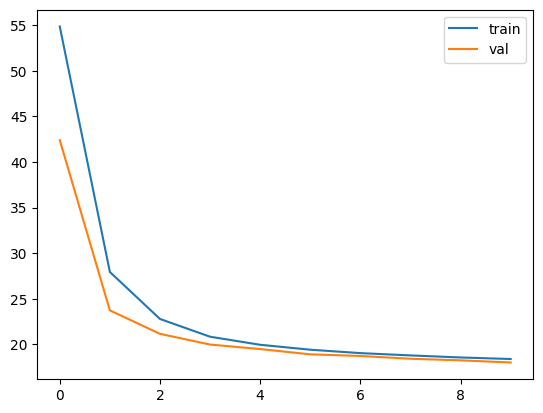

In [14]:
import matplotlib.pyplot as plt
plt.plot(trial_data[best_trial.number]['train_losses'], label='train')
plt.plot(trial_data[best_trial.number]['val_losses'], label='val')
plt.legend()
plt.show()

In [15]:
# evaluate on test set
X_test = torch.tensor(X_test_raw, dtype=torch.float32)
X_test = X_test.permute(0, 1, 2)
y_test = torch.tensor(y_test_raw, dtype=torch.float32)

criterion = nn.MSELoss()


In [16]:
# best_trial = {'num_layers': 2, 'dropout': 0.3907331240770967, 'hidden_size': 127, 'lr': 0.0004603846594084274}

In [17]:
best_trial.number

4

In [18]:
0.0004 == 4e-4

True

In [21]:

model = ForecastModel(best_trial, input_dim=8, output_dim=288).to(device)
model.eval()
model.load_state_dict(torch.load(f'./lstm_models/model_{best_trial.number}.pth'))


<All keys matched successfully>

In [22]:
best_trial.number

4

In [23]:
import torch.onnx

# Export the model
torch.onnx.export(model,               # model being run
                  torch.randn(1, 8, 288),                         # model input (or a tuple for multiple inputs)
                  "model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})


/mnt/ACA058A9A0587C30/Faks/Master/SIAP-NM/venv/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:4662: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [24]:

with torch.no_grad():
    # reshape the data
    X_test = X_test.permute(0, 2, 1)
    test_output = model(X_test.to(device))
    
    test_loss = criterion(test_output, y_test.to(device))
    
print(f'Test loss: {test_loss.item()}')


Test loss: 18.166906356811523


In [ ]:
X_test.shape

In [25]:
print(best_trial.params)

{'num_layers': 2, 'dropout': 0.20170039541085966, 'hidden_size': 75, 'lr': 0.000530766845802589}


In [26]:

for i in range(10):
    for j in range(0, len(y_test[i]), 24):
        print(f'Predicted: {test_output[i][j].item()}, True: {y_test[i][j].item()}')

    

Predicted: 17.389188766479492, True: 16.0
Predicted: 16.847089767456055, True: 17.0
Predicted: 14.716144561767578, True: 13.0
Predicted: 9.676603317260742, True: 20.0
Predicted: 5.108694553375244, True: 1.0
Predicted: 1.2729400396347046, True: 0.0
Predicted: 2.064178705215454, True: 0.0
Predicted: 13.422876358032227, True: 11.0
Predicted: 19.13338279724121, True: 21.0
Predicted: 18.1561222076416, True: 21.0
Predicted: 17.216108322143555, True: 15.0
Predicted: 0.0, True: 20.0
Predicted: 17.671350479125977, True: 16.0
Predicted: 17.502737045288086, True: 18.0
Predicted: 17.83201789855957, True: 20.0
Predicted: 16.286212921142578, True: 21.0
Predicted: 15.957582473754883, True: 14.0
Predicted: 15.924637794494629, True: 15.0
Predicted: 12.195647239685059, True: 9.0
Predicted: 8.673115730285645, True: 16.0
Predicted: 4.0374979972839355, True: 4.0
Predicted: 1.1551772356033325, True: 0.0
Predicted: 4.162004470825195, True: 0.0
Predicted: 0.0, True: 14.0
Predicted: 0.7764456868171692, True: 6

In [29]:
arr = y_test.detach().cpu().numpy()
smoothed_arr = np.empty_like(arr)

smoothed_arr = np.zeros_like(arr)
alpha = 0.8


In [30]:
print(arr.shape)

(1407, 288)


In [31]:

for i in range(1):
    moving_avg = arr[i, 0]
    for j in range(arr.shape[1]):
        moving_avg = moving_avg * alpha + arr[i, j] * (1 - alpha)
        smoothed_arr[i, j] = moving_avg


In [ ]:
print(smoothed_arr)

In [ ]:
smoothed_arr[0]

In [ ]:
print(smoothed_arr.shape)

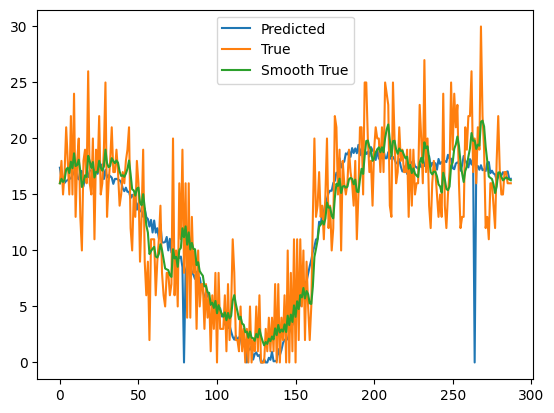

In [32]:
# plot the results
import matplotlib.pyplot as plt
plt.plot(test_output[0].cpu().numpy(), label='Predicted')
plt.plot(y_test[0].cpu().numpy(), label='True')
plt.plot(smoothed_arr[0], label='Smooth True')
plt.legend()
plt.show()
